### To get a rudimentary neural network working to classify pi+ vs pi0 using the depth, density, and cluster energy

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' #make sure I'm using the right GPU

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import pandas as pd
import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

plotpath = '/home/kaelaekd/start_tf/LCStudies/clusters/Plots/'

import sys
sys.path.append('/home/kaelaekd/start_tf/LCStudies')
from  util import resolution_util as ru
from  util import plot_util as pu

In [3]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4] #'image sizes' in phi/eta coords
len_eta = [128, 16, 8, 4, 4, 2]

path = '/fast_scratch/atlas_images/v7/'

branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']

In [4]:
p0_file = ur.open(path+'pi0.root')
p0_tree = p0_file['ClusterTree']
p0 = pd.DataFrame(p0_tree.arrays(expressions = branches, library='np'))

pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
pp = pd.DataFrame(pp_tree.arrays(expressions = branches, library='np')) 

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT 
p0['clusterEoverCalib'] = p0.clusterE / p0.cluster_ENG_CALIB_TOT

#### step one: define training set, training labels, and test set, and test labels
starting with just centermag to get it going

In [5]:
dataset = np.append(pp.cluster_CENTER_MAG, p0.cluster_CENTER_MAG)
labels = np.append(np.zeros(len(pp.cluster_CENTER_MAG)), np.ones(len(p0.cluster_CENTER_MAG)))
#idea is to have 0 = pp and 1 = p0 
dataset

array([2423.3179, 3425.6968, 3913.9963, ..., 1905.3357, 2048.6575,
       1668.8214], dtype=float32)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
data_train, data_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.3, random_state=1)
#data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size=0.2, random_state=1)

In [8]:
len(data_train), label_train #so I think now I have randomized input and test data!!??!!

(489900, array([0., 0., 1., ..., 1., 1., 0.]))

In [9]:
model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu'), tf.keras.layers.Dense(2)])
# then network consists of two Dense layers (128 = number of "nodes")

In [10]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [11]:
model.fit(data_train, label_train, epochs=10)#train model

Epoch 1/10
15310/15310 [==============================] - 35s 2ms/step - loss: 1.7566 - accuracy: 0.5905
Epoch 2/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.8615 - accuracy: 0.6484
Epoch 3/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.7696 - accuracy: 0.6572
Epoch 4/10
15310/15310 [==============================] - 34s 2ms/step - loss: 0.7230 - accuracy: 0.6605
Epoch 5/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.6462 - accuracy: 0.6653
Epoch 6/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.6107 - accuracy: 0.6703
Epoch 7/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.5584 - accuracy: 0.6769
Epoch 8/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.5291 - accuracy: 0.6854
Epoch 9/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.5106 - accuracy: 0.6961
Epoch 10/10
15310/15310 [==============================

In [12]:
test_loss, test_acc = model.evaluate(data_test,  label_test, verbose=2)
print('\nTest accuracy:', test_acc) 

6562/6562 - 10s - loss: 0.5106 - accuracy: 0.6871

Test accuracy: 0.6870754957199097


So first try with just depth does not great but works, build on it below

In [13]:
# okay lets try to add more stuff:
ppdat = np.column_stack((pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG)) #these should be in the same order as I haven't passed them to the train test split thing yet
p0dat = np.column_stack((p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG))
dataset2 = np.append(ppdat, p0dat, axis=0)
labels2 = np.append(np.zeros(len(pp.cluster_FIRST_ENG_DENS)), np.ones(len(p0.cluster_FIRST_ENG_DENS)))
#idea is to have 0 = pp and 1 = p0 
#these should be the same for eng dens and for center mag

In [14]:
dataset2.shape, ppdat.shape, labels2.shape

((699858, 2), (435967, 2), (699858,))

In [15]:
model2 = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_dim=2), 
                             tf.keras.layers.Dense(2)]) #need input_dim to say how many different datatype
# then network consists of two Dense layers (128 = number of "nodes")

model2.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [16]:
data_train2, data_test2, label_train2, label_test2 = train_test_split(dataset2, labels2, test_size=0.3, random_state=1)
#data_train2, data_val2, label_train2, label_val2 = train_test_split(data_train2, label_train2, test_size=0.2, random_state=1)

In [17]:
model2.fit(data_train2, label_train2, epochs=10)# 

Epoch 1/10
15310/15310 [==============================] - 34s 2ms/step - loss: 1.4381 - accuracy: 0.5941
Epoch 2/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.8834 - accuracy: 0.6491
Epoch 3/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.7609 - accuracy: 0.6579
Epoch 4/10
15310/15310 [==============================] - 34s 2ms/step - loss: 0.6989 - accuracy: 0.6634
Epoch 5/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.6677 - accuracy: 0.6640
Epoch 6/10
15310/15310 [==============================] - 34s 2ms/step - loss: 0.6132 - accuracy: 0.6693
Epoch 7/10
15310/15310 [==============================] - 35s 2ms/step - loss: 0.5729 - accuracy: 0.6734
Epoch 8/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.5472 - accuracy: 0.6798
Epoch 9/10
15310/15310 [==============================] - 33s 2ms/step - loss: 0.5344 - accuracy: 0.6842
Epoch 10/10
15310/15310 [==============================

In [18]:
test_loss, test_acc = model2.evaluate(data_test2,  label_test2, verbose=2)
print('\nTest accuracy:', test_acc) 

6562/6562 - 9s - loss: 0.5072 - accuracy: 0.7020

Test accuracy: 0.7020261287689209


### Here's the good stuff

Now that that's working, make function for however many types of data I might want, run below

In [19]:
from keras.utils import np_utils
from sklearn.metrics import roc_curve, auc

In [20]:
def dothething(ppdat_list, p0dat_list, epochs):
    """the lists need to be lists of data arrays or dataframe objs - the actual data to be used
    (see run below)
    formats the data, makes the model, trains and tests the model"""
    dim = len(ppdat_list) #get the data dimensions
    
    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        #tf.keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve
    ]
    
    ppdat = np.column_stack(ppdat_list) 
    p0dat = np.column_stack(p0dat_list)
    dataset = np.append(ppdat, p0dat, axis=0)
    labels = np.append(np.zeros(len(ppdat_list[0])), np.ones(len(p0dat_list[0])))#0 = pp, 1 = p0
    
    print(ppdat.shape, dataset.shape, labels.shape)
    
    data_train, data_test, label_train, label_test = train_test_split(dataset, labels, test_size=0.3, random_state=1)
    
    #need to one hot the labels!
    label_train_oh = np_utils.to_categorical(label_train, 2)
    label_test_oh = np_utils.to_categorical(label_test, 2)
    
    print(label_train.shape, label_train_oh.shape, label_train_oh[0])
    
    #seems to actually perform better without too many nodes!?
    model = tf.keras.Sequential([tf.keras.layers.Dense(30, activation='relu', input_dim=dim),
                                 #tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(30, activation='relu'),
                                 #tf.keras.layers.Dense(64, activation='relu', input_dim=dim),
                                 tf.keras.layers.Dense(2, kernel_initializer='normal', activation='softmax')]) #needed to specify softmax on last layer (why?)
    
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), #can't be sparse if using onehot!
                  metrics=METRICS)
    
    history = model.fit(data_train, label_train_oh, epochs=epochs)
    
    print('\n test accuracy:')
    test_results = model.evaluate(data_test,  label_test_oh, verbose=2)
    
    score = model.predict(data_test)
    fpr_pred, tpr_pred, _ = roc_curve(label_test_oh[:,1], score[:,1],drop_intermediate=False)
    auc_pred = auc(fpr_pred, tpr_pred)
    
    
    return history, fpr_pred, tpr_pred, auc_pred

In [21]:
ppdatlist = (pp.cluster_FIRST_ENG_DENS, pp.cluster_CENTER_MAG, pp.clusterE)
p0datlist = (p0.cluster_FIRST_ENG_DENS, p0.cluster_CENTER_MAG, p0.clusterE)

In [104]:
dothething(ppdatlist, p0datlist, epochs=4) #for 128, dropout, 128

(435967, 3) (699858, 3) (699858,)
Epoch 1/4
15310/15310 [==============================] - 37s 2ms/step - loss: 2.0227 - accuracy: 0.6611
Epoch 2/4
15310/15310 [==============================] - 37s 2ms/step - loss: 0.4706 - accuracy: 0.7498
Epoch 3/4
15310/15310 [==============================] - 37s 2ms/step - loss: 0.4594 - accuracy: 0.7613
Epoch 4/4
15310/15310 [==============================] - 37s 2ms/step - loss: 0.4557 - accuracy: 0.7634

 test accuracy:
6562/6562 - 8s - loss: 0.6281 - accuracy: 0.7066


In [106]:
dothething(ppdatlist, p0datlist, epochs=4) #for 128, 128 interesting seems like dropout doesn't help!!!

(435967, 3) (699858, 3) (699858,)
Epoch 1/4
15310/15310 [==============================] - 36s 2ms/step - loss: 2.6056 - accuracy: 0.6171
Epoch 2/4
15310/15310 [==============================] - 35s 2ms/step - loss: 0.4803 - accuracy: 0.7543
Epoch 3/4
15310/15310 [==============================] - 35s 2ms/step - loss: 0.4450 - accuracy: 0.7794
Epoch 4/4
15310/15310 [==============================] - 35s 2ms/step - loss: 0.4336 - accuracy: 0.7807

 test accuracy:
6562/6562 - 9s - loss: 0.4307 - accuracy: 0.7903


In [22]:
hist, FPR, TPR, AUC = dothething(ppdatlist, p0datlist, epochs=10) 
#looks like it changes every time so not actually better

(435967, 3) (699858, 3) (699858,)
(489900,) (489900, 2) [1. 0.]
Epoch 1/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.7856 - tp: 166597.3686 - fp: 78394.6267 - tn: 166597.3686 - fn: 78394.6267 - accuracy: 0.6626 - precision: 0.6626 - auc: 0.7359
Epoch 2/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.4708 - tp: 185397.9936 - fp: 59594.0017 - tn: 185397.9936 - fn: 59594.0017 - accuracy: 0.7534 - precision: 0.7534 - auc: 0.8510
Epoch 3/10
15310/15310 [==============================] - 99s 6ms/step - loss: 0.4501 - tp: 190027.8240 - fp: 54964.1713 - tn: 190027.8240 - fn: 54964.1713 - accuracy: 0.7751 - precision: 0.7751 - auc: 0.8697
Epoch 4/10
15310/15310 [==============================] - 96s 6ms/step - loss: 0.4434 - tp: 191356.0285 - fp: 53635.9668 - tn: 191356.0285 - fn: 53635.9668 - accuracy: 0.7811 - precision: 0.7811 - auc: 0.8750
Epoch 5/10
15310/15310 [==============================] - 98s 6ms/step - loss: 0.4416 - tp: 191623.5

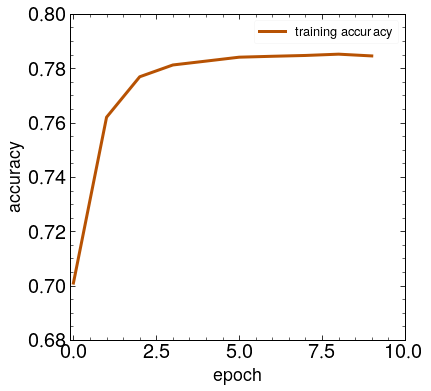

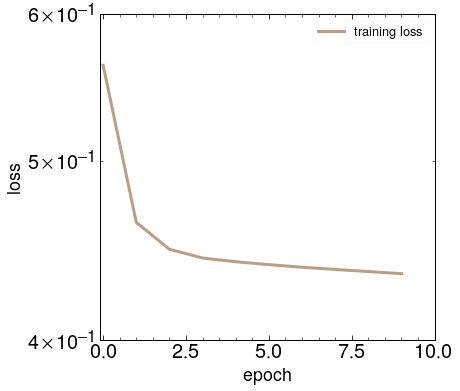

In [49]:
# plot loss during training
plt.figure(figsize=[6,6])
plt.xlim(-.1,10)
plt.plot(hist.history['accuracy'], label='training accuracy', c='xkcd:burnt siena', linewidth=3) #I think this is all the history object keeps, plus val stuff but idk about that yet
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('./Plots/train_acc')

# plot loss during training
plt.figure(figsize=[6,6])
plt.xlim(-.1,10)
plt.ylim(.4, .6)
plt.semilogy()
plt.plot(hist.history['loss'], label = 'training loss', c='xkcd:mushroom', linewidth=3) #it keeps the other metrics I sent it too!! sweeeeeeeettt!!!!!!!!
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('./Plots/train_loss')

### make ROC curve:

In [104]:
#this isn't right - is it because its from the training data? can you not make such a curve while training?
#only for the prediction? cause I think these functions should be right...

#tp = np.array(hist.history['tp'])
#fp = np.array(hist.history['fp'])
#tn = np.array(hist.history['tn'])
#fn = np.array(hist.history['fn'])

#tpr = tp/(tp+fn)
#fpr = fp/(fp+tn)

#tpr.shape

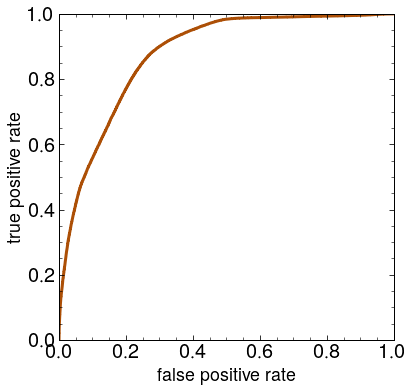

In [29]:
plt.figure(figsize=[6,6])
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(FPR, TPR, c='xkcd:cinnamon', linewidth=3)#okay got it now
plt.xlabel('false positive rate')
plt.ylabel('true positive rate') 
plt.savefig('./Plots/ROC1')

### AUC:

In [26]:
AUC #not 50% so that's good

0.8754618372745968

### effeciency/rejection plot:

<ipython-input-34-a4a3281b8d0e>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-10, 1.4e5)
<ipython-input-34-a4a3281b8d0e>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)


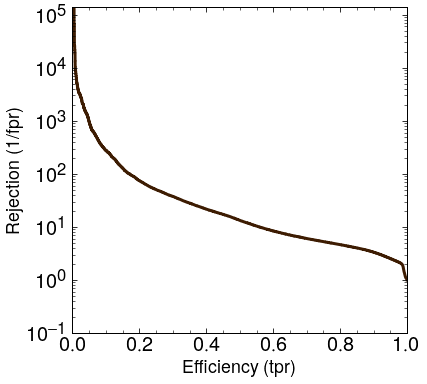

In [34]:
plt.figure(figsize=[6,6])
plt.xlim(0,1)
plt.semilogy()
plt.ylim(-10, 1.4e5)
plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
plt.xlabel('Efficiency (tpr)') #is this right?
plt.ylabel('Rejection (1/fpr)')
plt.savefig('./Plots/effrej.pdf')

Text(0, 0.5, 'training auc')

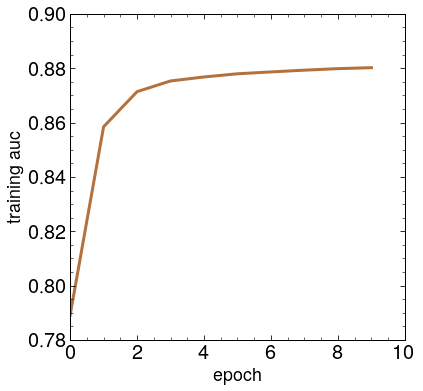

In [30]:
plt.figure(figsize=[6,6])
plt.xlim(0,10)
plt.plot(hist.history['auc'], c='xkcd:clay brown', linewidth=3)
plt.xlabel('epoch')
plt.ylabel('training auc')

In [36]:
from scipy.interpolate import interp1d

In [53]:
f = interp1d(TPR, 1/FPR)

<ipython-input-53-6e32f54f61d2>:1: RuntimeWarning: divide by zero encountered in true_divide
  f = interp1d(TPR, 1/FPR)


In [54]:
f(.95) #rejection at 95% efficiency

array(2.52824747)

<ipython-input-55-04965b66e56e>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-10, 1.4e5)
<ipython-input-55-04965b66e56e>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)


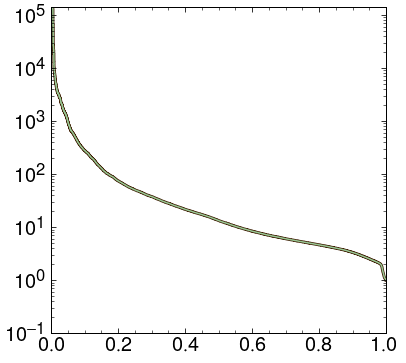

In [55]:
plt.figure(figsize=[6,6])
plt.xlim(0,1)
plt.semilogy()
plt.ylim(-10, 1.4e5)
plt.plot(TPR, 1/FPR, c='xkcd:chocolate', linewidth=3)
plt.plot(TPR, f(TPR)) #check to make sure it looks good

In [93]:
#the below didn't work out but idk might be useful later

In [47]:
#gonna try a different way from a different tutorial!
dic = {'cluster_CENTER_MAG':dataset, 'cluster_FIRST_ENG_DENS':dataset2, 'type':labels}
bothdata = pd.DataFrame(data=dic)

In [46]:
bothdatashuff = bothdata.reindex(np.random.permutation(bothdata.index))

In [60]:
feature_columns = [tf.feature_column.numeric_column('cluster_CENTER_MAG'), tf.feature_column.numeric_column('cluster_FIRST_ENG_DENS')]

In [70]:
feature_columns[0]

NumericColumn(key='cluster_CENTER_MAG', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [61]:
train_v, test = train_test_split(bothdatashuff, test_size=0.2)
train, val = train_test_split(train_v, test_size=0.2)

lab_t = train.pop('type')
lab_v = val.pop('type')
lab_ts = test.pop('type')

train_ds = tf.data.Dataset.from_tensor_slices((dict(train), lab_t))
val_ds =  tf.data.Dataset.from_tensor_slices((dict(val), lab_v))
test_ds =  tf.data.Dataset.from_tensor_slices((dict(test), lab_ts))

In [62]:
train_ds

<TensorSliceDataset shapes: ({cluster_CENTER-MAG: (), cluster_FIRST_ENG_DENS: ()}, ()), types: ({cluster_CENTER-MAG: tf.float32, cluster_FIRST_ENG_DENS: tf.float32}, tf.float64)>

In [63]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [64]:
model_n = tf.keras.Sequential([feature_layer,
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dense(2)])
# then network consists of two Dense layers (128 = number of "nodes")

In [65]:
model_n.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [66]:
model_n.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.


ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:389 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/feature_column/dense_features.py:168 call  **
        tensor = column.get_dense_tensor(transformation_cache,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2592 get_dense_tensor
        return transformation_cache.get(self, state_manager)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2355 get
        transformed = column.transform_feature(self, state_manager)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2564 transform_feature
        input_tensor = transformation_cache.get(self.key, state_manager)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2339 get
        raise ValueError('Feature {} is not in features dictionary.'.format(key))

    ValueError: Feature cluster_CENTER_MAG is not in features dictionary.
